>>>># **Fashion MNIST**

>>>>>Projekt PSZT 19L


>>>>> *Mateusz Nosek*

>>>>> *Łukasz Świtaj*



Niezbędne importy:
* **Keras** - sieć FFNN oraz CNN
* **OpenCV** - obróbka obrazów
* **sklearn** - GridSearch oraz MultiLayerPerceptron



In [0]:
from __future__ import absolute_import, division, print_function
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import cv2 as cv
from skimage import data, io, filters
from sklearn import datasets, svm, metrics, neural_network
from sklearn.model_selection import GridSearchCV

Funkcje pomocnicze dla pokazania **postępów w nauce sieci**

In [0]:
def plot_accuracy(history):
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  return

def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  return

Autorska **walidacja krzyżowa**

In [0]:
def cross_validation(train_and_val_set, test_set, test_labels, model, k, e, train_and_val_labels):
  before_weights = model.get_weights()
  
  validation_images = []
  validation_images.append(train_and_val_set[45000:60000])
  validation_images.append(train_and_val_set[30000:45000])
  validation_images.append(train_and_val_set[15000:30000])
  validation_images.append(train_and_val_set[:15000])
  
  validation_labels = []
  validation_labels.append(train_and_val_labels[45000:60000])
  validation_labels.append(train_and_val_labels[30000:45000])
  validation_labels.append(train_and_val_labels[15000:30000])
  validation_labels.append(train_and_val_labels[:15000])
  
  train_images = []
  train_images.append(train_and_val_set[:45000])
  temp = np.append(train_and_val_set[:30000], train_and_val_set[45000:])
  train_images.append(temp)
  temp = np.append(train_and_val_set[:15000], train_and_val_set[30000:])
  train_images.append(temp)
  train_images.append(train_and_val_set[15000:])
  
  train_labels = []
  train_labels.append(train_and_val_labels[:45000])
  temp = np.append(train_and_val_labels[:30000], train_and_val_labels[45000:])
  train_labels.append(temp)
  temp = np.append(train_and_val_labels[:15000],train_and_val_labels[30000:])
  train_labels.append(temp)
  train_labels.append(train_and_val_labels[15000:])
  
  best_acc = 0
  
  for i in range(0,4):
    train_images[i] = train_images[i].reshape(45000,28,28,1)
    
    history = model.fit(train_images[i], train_labels[i], batch_size=32, validation_data=(validation_images[i], validation_labels[i]), epochs=e, verbose=0)
    (loss, acc) = model.evaluate(test_set, test_labels, verbose = 0)
    if acc > best_acc:
      best_acc = acc
      best_history = history
    model.set_weights(before_weights)
      
  plot_accuracy(best_history)
  plot_loss(best_history)
  return best_acc

Wczytanie zestawu danych **Fashion MNIST**

In [7]:
(train_and_validation_images_normal, train_and_validation_labels), (test_images_normal, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

train_and_validation_images_normal = train_and_validation_images_normal / 255.0
test_images_normal = test_images_normal / 255.0

# zachowane dane dla sklearn
train_and_validation_images_before_reshaping = train_and_validation_images_normal
test_images_before_reshaping = test_images_normal

4423680/4422102 [==============================] - 1s 0us/step


OpenCV

Nałożenie efektu **erozji**, przykład na danych z zestawu mnist:

---
![alt text](https://docs.opencv.org/2.4/_images/Morphology_1_Tutorial_Theory_Erosion_2.png)

In [0]:
kernel = np.ones((3,3),np.uint8)
train_and_validation_images_eroded = cv.erode(train_and_validation_images_normal, kernel, iterations = 1)
test_images_eroded = cv.erode(test_images_normal, kernel, iterations = 1)

OpenCV

Efekt **morphologyEx** - stworzenie prostego obrysu.
___
![alt text](https://docs.opencv.org/3.0-beta/_images/gradient.png)

In [0]:
kernel = np.ones((3,3),np.uint8)
train_and_validation_images_morphologied = cv.erode(train_and_validation_images_normal, kernel, iterations = 1)
test_images_morphologied = cv.erode(test_images_normal, kernel, iterations = 1)

Przygotowanie zmiennych pomoczniczych

In [0]:
# agregat na modele
models = []

# liczba epochów treningowych
e = 4

# k - krotność walidacji krzyżowej - w tym przykladzie na sztywno zdefiniowana 4-krotna
k = 4

# zestawy danych treningowych, walidacyjnych i testowych
train_and_val_sets = [train_and_validation_images_normal, train_and_validation_images_eroded, train_and_validation_images_morphologied]
train_and_val_labels = [train_and_validation_labels, train_and_validation_labels, train_and_validation_labels]
test_sets = [test_images_normal, test_images_eroded, test_images_morphologied]
test_labels = [test_labels, test_labels, test_labels]
name_sets = ['normal', 'eroded', 'morphologied']

Zmiana formatu danych dla sieci konwolucyjnych

In [0]:
for i in range(0, len(train_and_val_sets)):
  train_and_val_sets[i] = train_and_val_sets[i].reshape(60000,28,28,1)
  test_sets[i] = test_sets[i].reshape(10000,28,28,1)

**Sieci FFNN**:
* nr 1 - 3 - proste sieci FFNN
* nr 4 - sieć z dodanymi warstwami Dropout pomiędzy każdą kolejną warstwą

In [12]:
models.append(Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(392, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')]))
models.append(Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(588, activation='relu'),
    Dense(196, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')]))
models.append(Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(300, activation='relu'),
    Dense(100, activation='relu'),
    Dense(10, activation='softmax')]))
models.append(Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(392, activation='relu'),
    Dropout(0.3),
    Dense(196, activation='relu'),
    Dropout(0.2),
    Dense(98, activation='relu'),
    Dropout(0.1),
    Dense(49, activation='relu'),
    Dropout(0.05),
    Dense(10, activation='softmax')]))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


**Sieci CNN**:
* nr 1 - prosta sieć konwolucyjna
* nr 2 - sieć 1 z dodaną dodatkową wartstwą MaxPoolingową
* nr 3, 4 - dodana warstwa Dropoutu
* nr 5 - sieć o architekturze wielowarstwowej oparta na modelu: warstwa konwolucyjna ->maxpoolingowa->dropout

In [0]:
models.append(Sequential([
    Conv2D(28, kernel_size=4, activation='relu', input_shape=(28,28,1)),
    Conv2D(14, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(10, activation='softmax')]))
models.append(Sequential([
    Conv2D(28, kernel_size=4, activation='relu', input_shape=(28,28,1)),
    Conv2D(14, kernel_size=3, activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(10, activation='softmax')]))
models.append(Sequential([
    Conv2D(28, kernel_size=4, activation='relu', input_shape=(28,28,1)),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')]))
models.append(Sequential([
    Conv2D(28, kernel_size=4, activation='relu', input_shape=(28,28,1)),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')]))
models.append(Sequential([
    Conv2D(28, kernel_size=4, activation='relu', input_shape=(28,28,1)),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    Conv2D(56, kernel_size=4, activation='relu', input_shape=(28,28,1)),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    Conv2D(102, kernel_size=4, activation='relu', input_shape=(28,28,1)),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')]))

Trenowanie oraz zebranie danych o skuteczności sieci

normal
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 392)               307720    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                25152     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 333,522
Trainable params: 333,522
Non-trainable params: 0
_________________________________________________________________
None


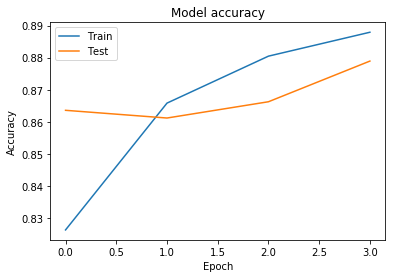

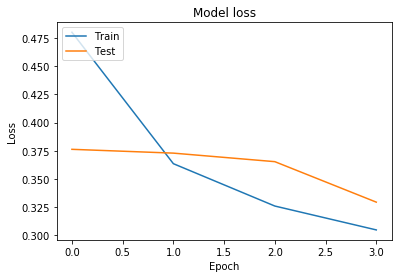

0.8702
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 588)               461580    
_________________________________________________________________
dense_5 (Dense)              (None, 196)               115444    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                12608     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                650       
Total params: 590,282
Trainable params: 590,282
Non-trainable params: 0
_________________________________________________________________
None


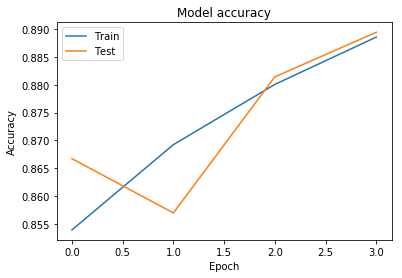

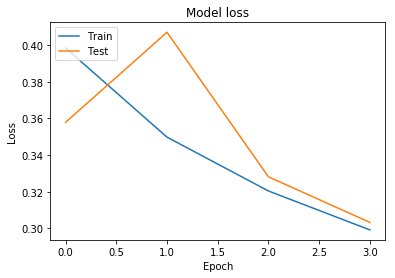

0.874
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_9 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
None


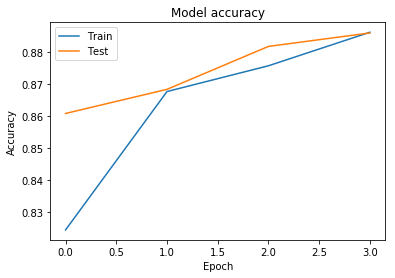

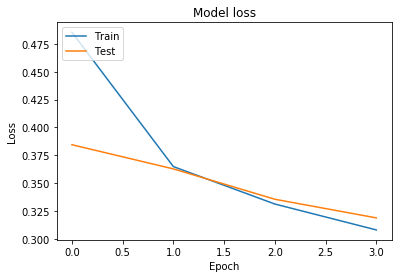

0.8737
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 392)               307720    
_________________________________________________________________
dropout_1 (Dropout)          (None, 392)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 196)               77028     
_________________________________________________________________
dropout_2 (Dropout)          (None, 196)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 98)                19306     
_________________________________________________________________
dropout_3 (Dropout)          (None, 98)                0         
___

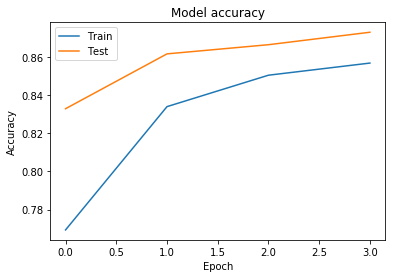

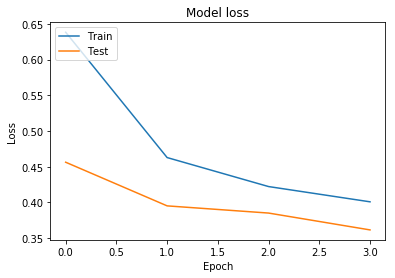

0.8652
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 25, 25, 28)        476       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 14)        3542      
_________________________________________________________________
flatten_5 (Flatten)          (None, 7406)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                74070     
Total params: 78,088
Trainable params: 78,088
Non-trainable params: 0
_________________________________________________________________
None


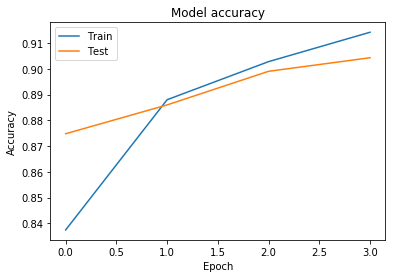

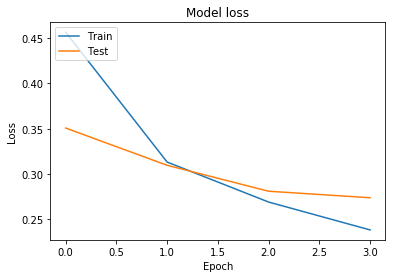

0.8997
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 25, 25, 28)        476       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 23, 14)        3542      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 14)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1694)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                16950     
Total params: 20,968
Trainable params: 20,968
Non-trainable params: 0
_________________________________________________________________
None


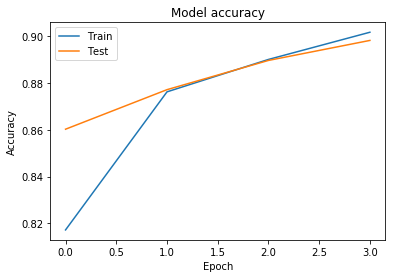

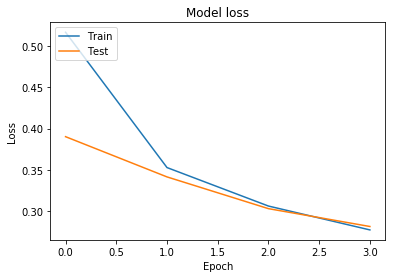

0.8971
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 25, 25, 28)        476       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 28)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 28)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 4032)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                258112    
_________________________________________________________________
dense_19 (Dense)             (None, 10)                650       
Total params: 259,238
Trainable params: 259,238
Non-trainable params: 0
_______________________________________________________________

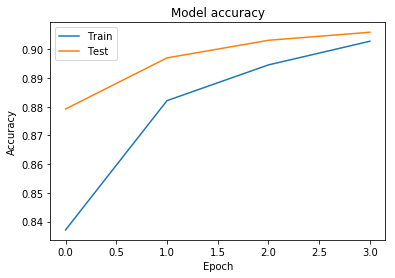

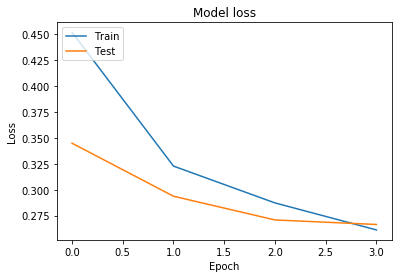

0.896
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 25, 25, 28)        476       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 28)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 12, 12, 28)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 4032)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                258112    
_________________________________________________________________
dense_21 (Dense)             (None, 10)                650       
Total params: 259,238
Trainable params: 259,238
Non-trainable params: 0
________________________________________________________________

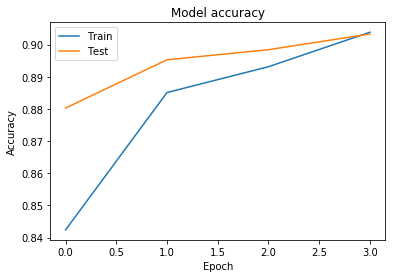

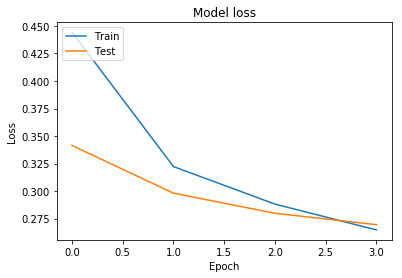

0.8962
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 25, 25, 28)        476       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 28)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 12, 12, 28)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 56)          25144     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 56)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 4, 4, 56)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 1, 102)         91494     
___

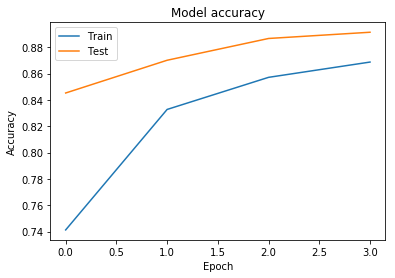

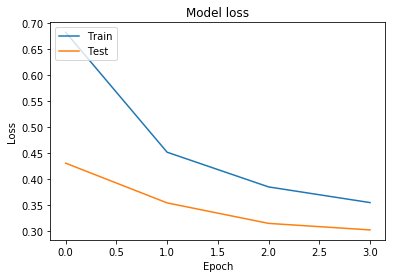

0.8828
eroded
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 392)               307720    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                25152     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 333,522
Trainable params: 333,522
Non-trainable params: 0
_________________________________________________________________
None


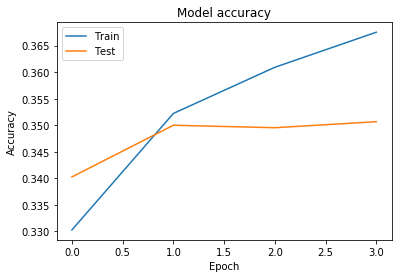

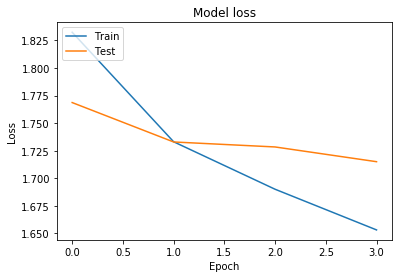

0.3521
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 588)               461580    
_________________________________________________________________
dense_5 (Dense)              (None, 196)               115444    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                12608     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                650       
Total params: 590,282
Trainable params: 590,282
Non-trainable params: 0
_________________________________________________________________
None


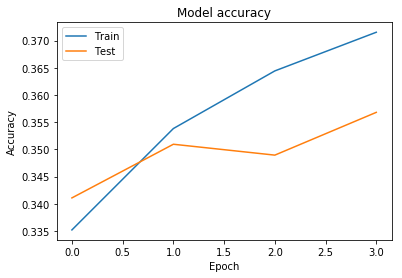

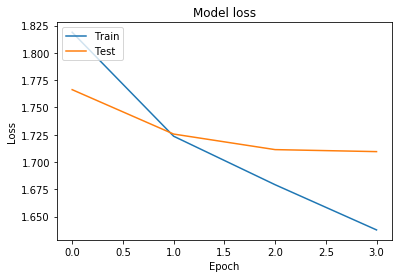

0.361
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_9 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
None


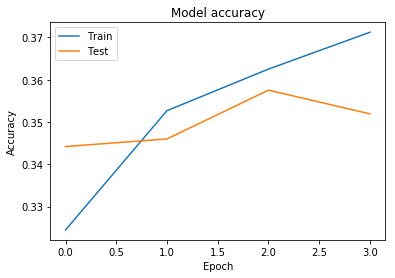

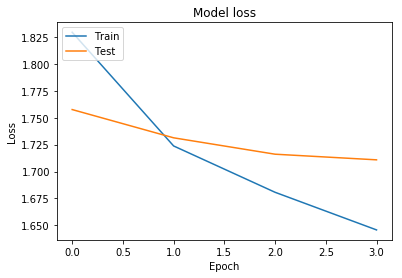

0.3587
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 392)               307720    
_________________________________________________________________
dropout_1 (Dropout)          (None, 392)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 196)               77028     
_________________________________________________________________
dropout_2 (Dropout)          (None, 196)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 98)                19306     
_________________________________________________________________
dropout_3 (Dropout)          (None, 98)                0         
___

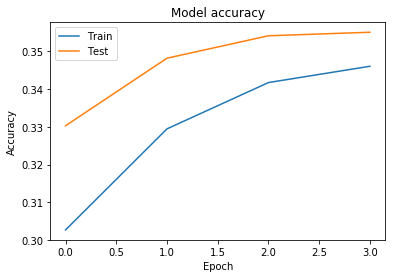

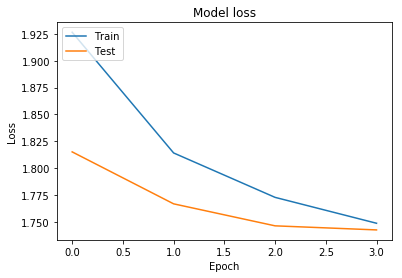

0.3617
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 25, 25, 28)        476       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 14)        3542      
_________________________________________________________________
flatten_5 (Flatten)          (None, 7406)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                74070     
Total params: 78,088
Trainable params: 78,088
Non-trainable params: 0
_________________________________________________________________
None


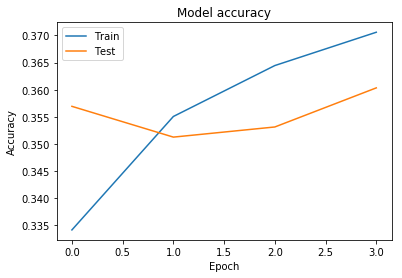

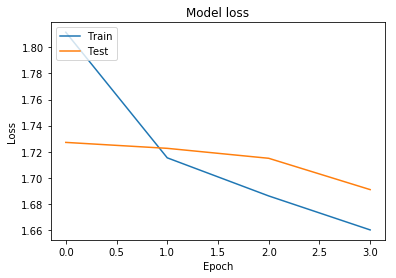

0.3697
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 25, 25, 28)        476       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 23, 14)        3542      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 14)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1694)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                16950     
Total params: 20,968
Trainable params: 20,968
Non-trainable params: 0
_________________________________________________________________
None


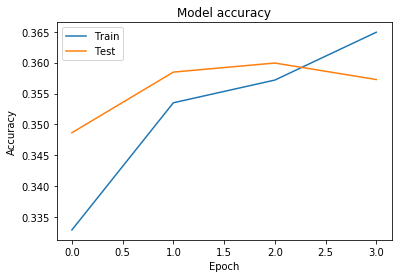

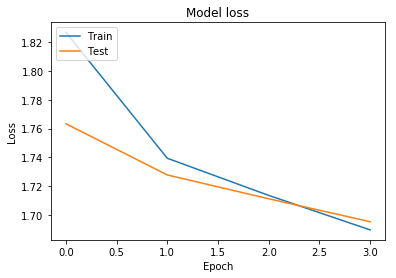

0.3692
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 25, 25, 28)        476       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 28)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 28)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 4032)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                258112    
_________________________________________________________________
dense_19 (Dense)             (None, 10)                650       
Total params: 259,238
Trainable params: 259,238
Non-trainable params: 0
_______________________________________________________________

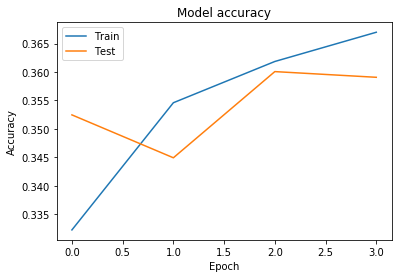

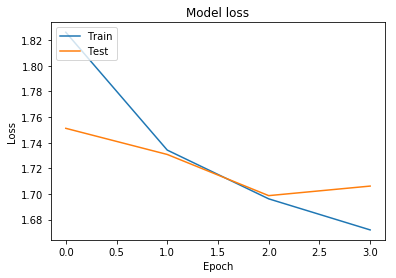

0.367
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 25, 25, 28)        476       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 28)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 12, 12, 28)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 4032)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                258112    
_________________________________________________________________
dense_21 (Dense)             (None, 10)                650       
Total params: 259,238
Trainable params: 259,238
Non-trainable params: 0
________________________________________________________________

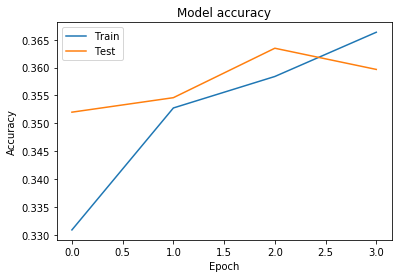

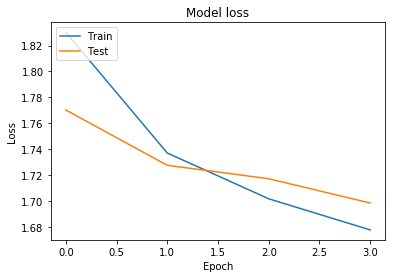

0.3641
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 25, 25, 28)        476       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 28)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 12, 12, 28)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 56)          25144     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 56)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 4, 4, 56)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 1, 102)         91494     
___

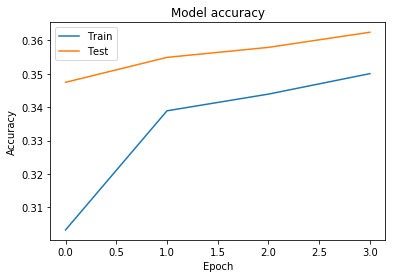

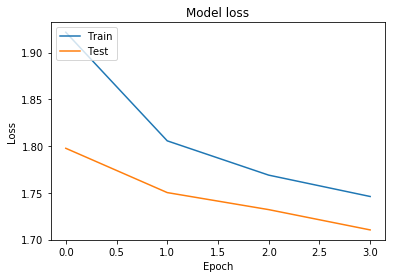

0.3634
morphologied
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 392)               307720    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                25152     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 333,522
Trainable params: 333,522
Non-trainable params: 0
_________________________________________________________________
None


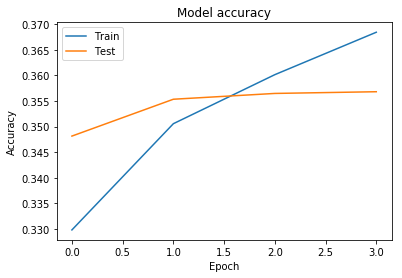

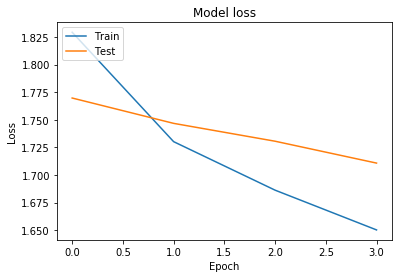

0.3603
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 588)               461580    
_________________________________________________________________
dense_5 (Dense)              (None, 196)               115444    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                12608     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                650       
Total params: 590,282
Trainable params: 590,282
Non-trainable params: 0
_________________________________________________________________
None


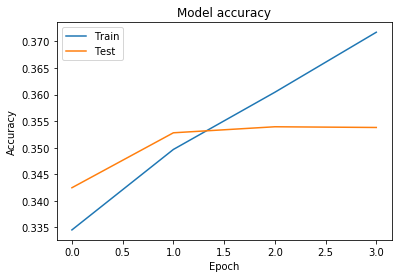

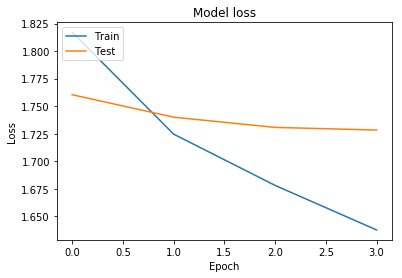

0.3526
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_9 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
None


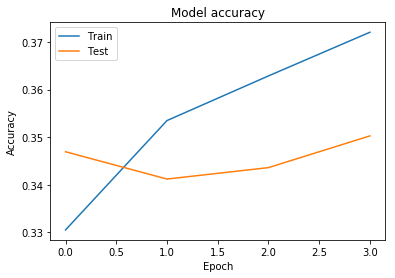

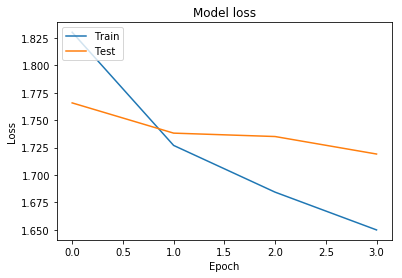

0.3601
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 392)               307720    
_________________________________________________________________
dropout_1 (Dropout)          (None, 392)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 196)               77028     
_________________________________________________________________
dropout_2 (Dropout)          (None, 196)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 98)                19306     
_________________________________________________________________
dropout_3 (Dropout)          (None, 98)                0         
___

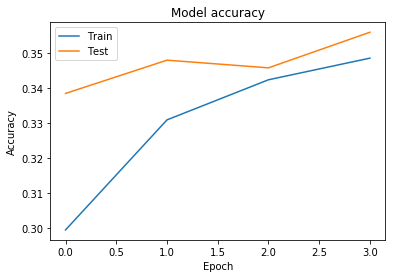

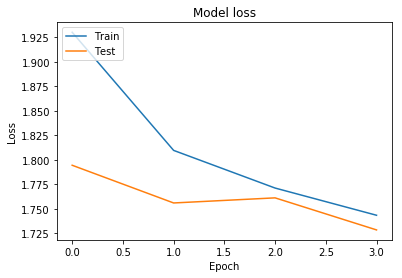

0.3536
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 25, 25, 28)        476       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 14)        3542      
_________________________________________________________________
flatten_5 (Flatten)          (None, 7406)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                74070     
Total params: 78,088
Trainable params: 78,088
Non-trainable params: 0
_________________________________________________________________
None


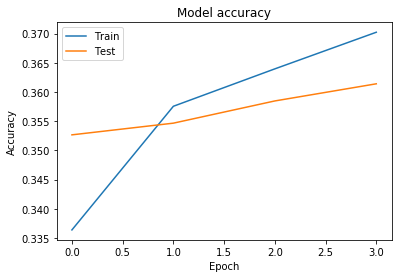

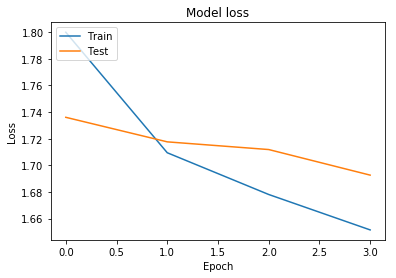

0.364
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 25, 25, 28)        476       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 23, 14)        3542      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 14)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1694)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                16950     
Total params: 20,968
Trainable params: 20,968
Non-trainable params: 0
_________________________________________________________________
None


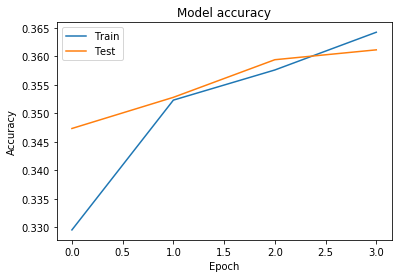

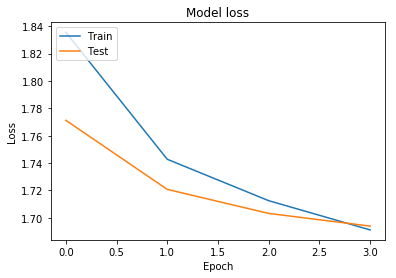

0.3683
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 25, 25, 28)        476       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 28)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 28)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 4032)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                258112    
_________________________________________________________________
dense_19 (Dense)             (None, 10)                650       
Total params: 259,238
Trainable params: 259,238
Non-trainable params: 0
_______________________________________________________________

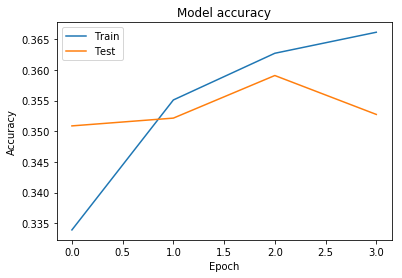

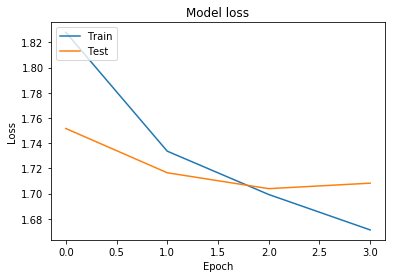

0.3672
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 25, 25, 28)        476       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 28)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 12, 12, 28)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 4032)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                258112    
_________________________________________________________________
dense_21 (Dense)             (None, 10)                650       
Total params: 259,238
Trainable params: 259,238
Non-trainable params: 0
_______________________________________________________________

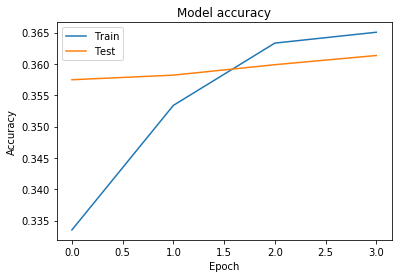

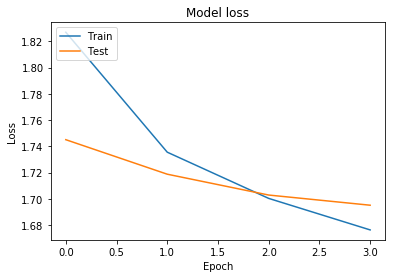

0.3707
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 25, 25, 28)        476       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 28)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 12, 12, 28)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 56)          25144     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 56)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 4, 4, 56)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 1, 102)         91494     
___

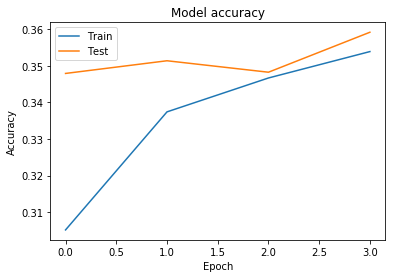

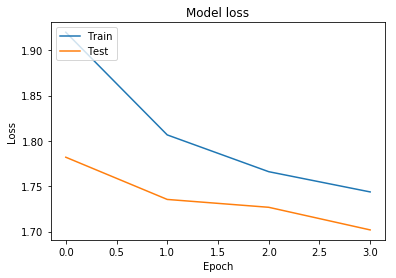

0.3625


In [72]:
for (train_and_val_set, train_and_val_label, test_set, test_label, name_set) in zip(train_and_val_sets, train_and_val_labels, test_sets, test_labels, name_sets):
  print(name_set)
  for model in models:
    print(model.summary())
    model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    acc = cross_validation(train_and_val_set, test_set, test_label, model, k, e, train_and_val_label)
    print(acc)

**sklearn**

Zastosowanie Perceptronu wielowarstowego

In [0]:
nsamples_tv, x, y = train_and_validation_images_before_reshaping.shape
mlp_train_and_validation_images = train_and_validation_images_before_reshaping.reshape((nsamples_tv,x*y))

nsamples_t, x, y = test_images_before_reshaping.shape
mlp_test_images = test_images_before_reshaping.reshape((nsamples_t,x*y))

In [75]:
classifier = neural_network.MLPClassifier(alpha=1, max_iter=1000)
classifier.fit(mlp_train_and_validation_images, train_and_validation_labels)

MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [77]:
predicted_labels = classifier.predict(mlp_test_images)
print(metrics.accuracy_score(test_labels[0],predicted_labels))

0.8508


Grid Search dla MLP

In [0]:
clf = neural_network.MLPClassifier()
grid_values = {'activation': ['relu', 'tanh'],'learning_rate':['constant', 'adaptive']}
grid_clf_acc = GridSearchCV(neural_network.MLPClassifier(), param_grid = grid_values, scoring = 'accuracy')
grid_clf_acc.fit(mlp_train_and_validation_images, train_and_validation_labels)

Niestety Grid Search dla wbudowanych rozwiązań jest zbyt obciażający. Output wyprodukowany po 3745 sekundach:

*/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'activation': ['relu', 'tanh'], 'learning_rate': ['constant', 'adaptive']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)*

Wnioski:
- proste sieci FFNN mają dobry współczynnik skuteczności do czasu nauki (maks. accuracy ok 87%)
- głębokie sieci FFNN mimo większej ilości warstw i parametrów nie okazują się dużo lepsze od prostych (maks. accuracy ok 88%)
- co nieco zaskakujące wskaźnik accuracy stabilizuje się już około 3 treningu, możemy powiedzieć, że działa tu wzmocniona zasada pareto
- sieci konwolucyjne o prostej architekturze lepiej radzą sobie z zadaniem ze względu na to, że tworzone były właśnie z myślą o przetwarzaniu obrazów (maks. accuracy ok 90%)
- niespodziewanie najskuteczniejszą siecią konwolucyjną okazała się ta o najprostszej architekturze - dwie warstwy konwolucyjne, prawdopodobnie taka warstwa jak np. maxpooling byłaby lepsza dla obrazów o większej złożoności i ilości szczegółów
- zastosowanie filtru erozyjnego było błędem - myśleliśmy, że 'korpus'/część główna obrazów reprezentujących ubrania będzie taka sama jednakże okazała się tylko zmyleniem dla sieci (skuteczność ok 35%) i niska skuteczność nie jest winą sieci - wszystkie osiągnęły podobny rezultat
- podobny wniosek co do filtru "obrysowego" - morphology (36/37%)
- dołożenie jakichkolwiek filtrów na obraz miałoby sens w przypadku gdyby zdjęcia miały wymiar kilkakrotnie większy - przy rozmiarze 28\*28 pikseli trudno dodać coś dodatkowego
- wbudowany algorytm perceptronu wielowarstwowego z biblioteki sklearn jest mniej wydajny niż rozwiązania "pisane na miarę" (jak wyżej zaimplementowane sieci), czasowo również nie jest lepszy
